In [5]:
from sklearn.preprocessing import MinMaxScaler
from joblib import dump
import plotly.express as px
import yfinance as yf
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [6]:
def split_dataframe(
    df: pl.DataFrame,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
):
    total_rows = df.height
    train_end = int(total_rows * train_ratio)
    val_end = train_end + int(total_rows * val_ratio)

    return df.with_columns(
        pl.when(pl.arange(0, df.height) < train_end)
        .then(pl.lit("train"))
        .when(pl.arange(0, df.height) < val_end)
        .then(pl.lit("val"))
        .otherwise(pl.lit("test"))
        .alias("split_type")
    )

In [7]:
def normalization(scaler_class, df: pl.DataFrame):
    scaler_name = str(scaler_class).split(".")[-1].replace("'>", "")

    train_close = (
        df.filter(pl.col("split_type") == "train")["Close"].to_numpy().reshape(-1, 1)
    )

    scaler = scaler_class()

    scaler.fit(train_close)

    return df.with_columns(
        pl.Series(
            f"Close_{scaler_name}",
            scaler.transform(df["Close"].to_numpy().reshape(-1, 1)).flatten(),
        )
    )

In [1]:
msft = yf.Ticker("SPOT")

hist = msft.history(period="5y")
hist.to_csv("../data/raw/spot.csv")

In [8]:
df = (
    pl.read_csv("../data/raw/spot.csv")
        .with_columns(
            pl.col('Date')
                .str
                .to_datetime()
                .dt
                .date()
        )
        .select(
            pl.col(
                [
                    'Date',
                    'Close'
                ]
            )
        )
)

In [9]:
df = split_dataframe(df)
df.head()

Date,Close,split_type
date,f64,str
2019-09-24,116.800003,"""train"""
2019-09-25,118.220001,"""train"""
2019-09-26,116.199997,"""train"""
2019-09-27,112.239998,"""train"""
2019-09-30,114.0,"""train"""


In [16]:
df.shape

(1258, 3)

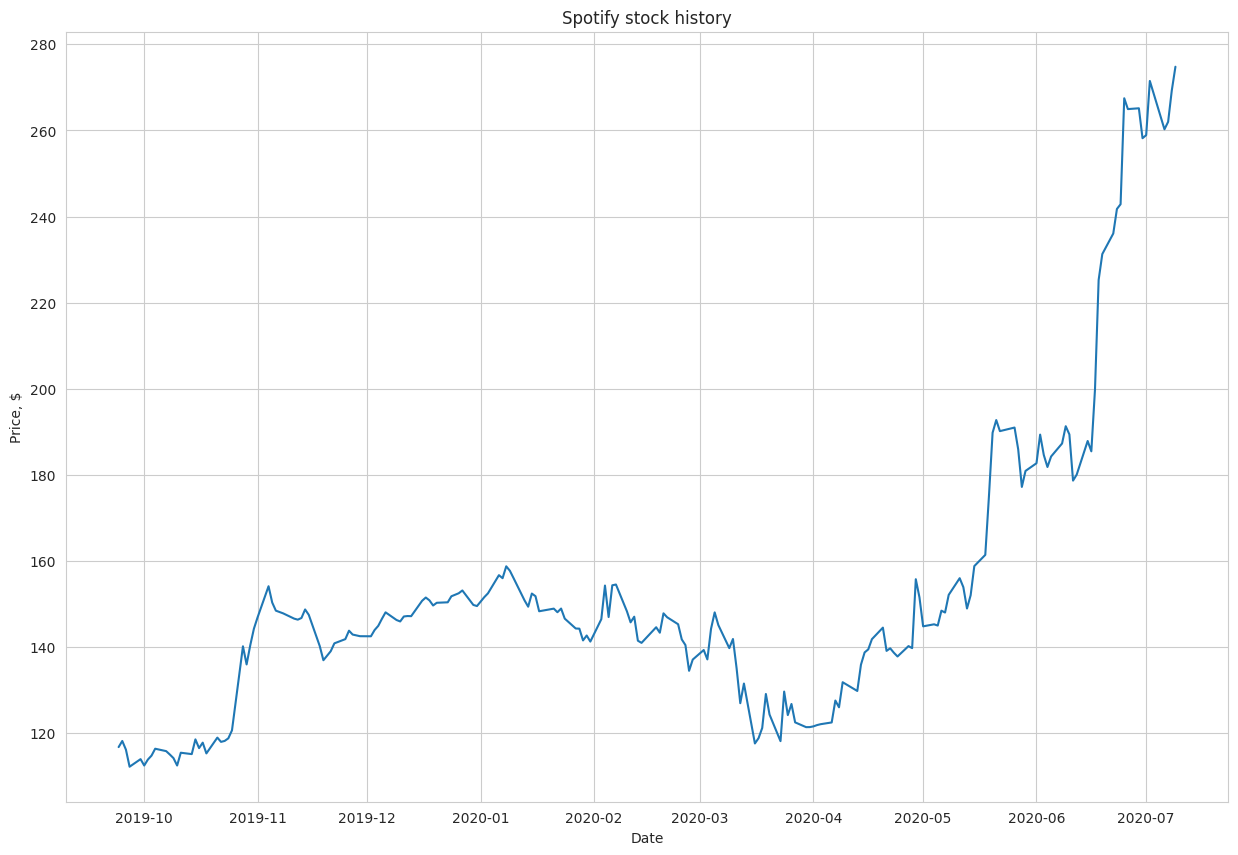

In [15]:
plt.figure(figsize=(15, 10))

sns.lineplot(data=df[:200], x='Date', y='Close',)

plt.title("Spotify stock history")

plt.xlabel("Date")
plt.ylabel('Price, $')
plt.show()

In [18]:
df = normalization(MinMaxScaler, df)

In [20]:
df.write_csv('../data/processed/spot.csv')

In [21]:
scaler = MinMaxScaler()

In [22]:
train_data = df.filter(pl.col("split_type") == "train")

In [24]:
scaler.fit(train_data["Close"].to_numpy().reshape(-1, 1))

MinMaxScaler()

In [28]:
dump(scaler, "../data/processed/scaler_spot.joblib")

['../data/processed/scaler_spot.joblib']